In [1]:
# import fiona
from shapely.geometry import *
from shapely.wkt import loads
# from shapely import LineString, MultiPoint
# from shapely.ops import nearest_points, split, snap, unary_union

import contextily as cx
# import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xarray as xr
# import shapely

#### Functions

In [2]:
def readNHD(index):
    ## Set-up
    mdata_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/'
    prep_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped/' # _with_waterbody

    # Define dtypes for lookup tables to preserve leading zeros
    dtype_dic= {'HUC4': str, 'HUC2': str, 'toBasin': str, 'level': str}
    # Read in HUC lookup table
    lookup = pd.read_csv(os.path.join(mdata_path, 'HUC4_lookup_no_great_lakes.csv'), dtype=dtype_dic)

    # Get current HUC2 and HUC4 IDs
    hu2 = 'HUC2_' + lookup.loc[index,'HUC4'][0:2]
    hu4 = 'NHDPLUS_H_' + lookup.loc[index,'HUC4'] + '_HU4_GDB'
    
    # Set data filepath
    file_path = os.path.join(prep_path, hu2, hu4 + '_prepped.gpkg') # _with_waterbody

    ## Read in prepped NHD flowlines
    features = ['NHDPlusID', 'GNIS_Name', 'LengthKM', 'WidthM', 'Bin', 'geometry']
    basin = gpd.read_file(filename=file_path, columns=features, engine='pyogrio')
    
    # Make geometry 2D LineStrings
    basin['geometry'] = basin.geometry.explode().force_2d()
    return basin

In [3]:
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    # Returns the trimmed piece and the remainder of the linestring
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

In [4]:
def bitwiseMask(ds):
    # Fow now, remove pixels with land classification and
    # geolocation_qual very not good
    # See page 65 of PIXC PDD: https://podaac.jpl.nasa.gov/SWOT?tab=datasets-information&sections=about%2Bdata
    mask = np.where(np.logical_and(ds.classification > 1, ds.geolocation_qual < 2**12))[0]
    print(mask.shape)
    return mask

In [5]:
def makeGDF(ds, mask, data_var):
    # This function takes the pixel cloud, makes a GeoDataFrame,
    # renames columns as needed, projects the CRS, and returns
    # the GDF 

    # Create GDF
    gdf_PIXC = gpd.GeoDataFrame(ds[data_var][mask],
                                geometry=gpd.points_from_xy(
                                    ds.longitude[mask],
                                    ds.latitude[mask]),
                                crs="EPSG:4326") # PIXC has no native CRS, setting same as River_SP

    if data_var == 'classification':
        gdf_PIXC.rename(columns={gdf_PIXC.columns[0]: 'klass'}, inplace=True)
    else:
        gdf_PIXC.rename(columns={gdf_PIXC.columns[0]: data_var}, inplace=True)
    
    # Convert the crs to WGS 84 / Pseudo-Mercator
    gdf_PIXC = gdf_PIXC.to_crs(epsg=3857)
    return gdf_PIXC

In [61]:
def segmentReach(reach):
'''
Ths function XXX
'''
    # Get linestring
    line = reach.geometry
    # Find length of segments
    dist = line.length/10
    
    # Make empty list for segments
    segments = []

    # Segment the reach
    for i in range(9):
        # Chop the reach, store remainder
        new, line = cut(line=line, distance=dist)
        # Append new segment to GeoSeries of all segments
        segments.append(new)
        # segments[i]: new
    
    # Append final segment to list
    segments.append(line)

    return segments

**TESTING**

In [122]:
test = basin_crop.sample(n=5)
test

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry
7656,"(0, 10]",None,0.037,1.000090e+13,1.344763,"LINESTRING (-8042697.158 5173579.407, -8042703..."
13431,"(0, 10]",None,0.192,1.000090e+13,5.710564,"LINESTRING (-8038777.874 5203098.395, -8038777..."
20673,"(10, 20]",Chicopee Brook,1.076,1.000090e+13,16.984419,"LINESTRING (-8050050.15 5182051.861, -8050035...."
20201,"(0, 10]",None,0.287,1.000090e+13,2.141918,"LINESTRING (-8059423.25 5165463.762, -8059419...."
7664,"(0, 10]",None,0.472,1.000090e+13,1.620911,"LINESTRING (-8040738.198 5190563.162, -8040743..."


In [123]:
# Try with apply()
# test['segments'] = test.apply(segmentReach, axis=1)

test['segments'] = test.apply(func=segmentReach, axis=1)

In [125]:
test = test.explode(column='segments').reset_index()

In [126]:
test = test.set_geometry(col='segments').rename(columns={'geometry': 'geometry_full'})

In [129]:
assert test.geometry.name == 'segments'

In [130]:
test['new_index'] = test.groupby('index').cumcount()

In [131]:
test

,index,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry_full,segments,new_index
0,7656,"(0, 10]",None,0.037,1.000090e+13,1.344763,"LINESTRING (-8042697.158 5173579.407, -8042703...","LINESTRING (-8042697.158 5173579.407, -8042701...",0
1,7656,"(0, 10]",None,0.037,1.000090e+13,1.344763,"LINESTRING (-8042697.158 5173579.407, -8042703...","LINESTRING (-8042701.734 5173581.362, -8042703...",1
2,7656,"(0, 10]",None,0.037,1.000090e+13,1.344763,"LINESTRING (-8042697.158 5173579.407, -8042703...","LINESTRING (-8042705.826 5173584.124, -8042707...",2
3,7656,"(0, 10]",None,0.037,1.000090e+13,1.344763,"LINESTRING (-8042697.158 5173579.407, -8042703...","LINESTRING (-8042709.907 5173586.957, -8042714...",3
4,7656,"(0, 10]",None,0.037,1.000090e+13,1.344763,"LINESTRING (-8042697.158 5173579.407, -8042703...","LINESTRING (-8042714.125 5173589.598, -8042714...",4
5,7656,"(0, 10]",None,0.037,1.000090e+13,1.344763,"LINESTRING (-8042697.158 5173579.407, -8042703...","LINESTRING (-8042718.015 5173592.7, -8042718.5...",5
6,7656,"(0, 10]",None,0.037,1.000090e+13,1.344763,"LINESTRING (-8042697.158 5173579.407, -8042703...","LINESTRING (-8042721.798 5173595.931, -8042724...",6
7,7656,"(0, 10]",None,0.037,1.000090e+13,1.344763,"LINESTRING (-8042697.158 5173579.407, -8042703...","LINESTRING (-8042725.494 5173599.259, -8042729...",7
8,7656,"(0, 10]",None,0.037,1.000090e+13,1.344763,"LINESTRING (-8042697.158 5173579.407, -8042703...","LINESTRING (-8042729.01 5173602.781, -8042730....",8
9,7656,"(0, 10]",None,0.037,1.000090e+13,1.344763,"LINESTRING (-8042697.158 5173579.407, -8042703...","LINESTRING (-8042732.365 5173606.45, -8042735....",9


In [134]:
test.iloc[0:10].apply(func=getCoverage)

TypeError: getCoverage() missing 1 required positional argument: 'reach_cut'

In [ ]:
test.groupby(['index']).apply(func=getCoverage)

In [133]:
def getCoverage(gdf_PIXC=gdf_PIXC, reach_cut):
    '''
    Ths function XXX
    '''
    
    # Buffer the reach segments by 1/2 the calculated width
    # CITE BEIGER
    reach_cut['geometry'] = reach_cut.geometry.buffer(distance=(reach_cut.WidthM/2)[0], cap_style='flat')
    
    # Get pixels in reach
    inside = gpd.sjoin(gdf_PIXC, reach_cut, how='inner', predicate='within').rename(columns={'index_right': 'segment'})

    if inside.empty:
        prop = 0
    else:    
        # Get number of pixels in each reach segment
        counts = pd.DataFrame(inside.segment.value_counts().reset_index().sort_index())
        # print(counts)
        # Calculate coverage
        prop = len(counts.loc[counts['count'] != 0])/10
        # print(prop)
    return prop

SyntaxError: parameter without a default follows parameter with a default (308929227.py, line 1)

#### Read in and prep NHD

In [8]:
# Set slurm job index
i = 4 # HUC4 0108, Connecticut
# i = 109 # HUC4 1711, Snoqualmie

In [9]:
# Read prepped NHD
basin = readNHD(index=i)

#### Read in and prep PIXC

In [10]:
# pixc_path = '../data/small_rivers/mar_2024_ver_c/SWOT_L2_HR_PIXC_011_345_239R_20240227T044209_20240227T044220_PIC0_01.nc'
pixc_path = '../data/small_rivers/mar_2024_ver_c/leaf_off/SWOT_L2_HR_PIXC_014_341_229R_20240429T152954_20240429T153005_PIC0_01.nc'

In [11]:
tile_name = pixc_path[-71:-3]
tile_name

'SWOT_L2_HR_PIXC_014_341_229R_20240429T152954_20240429T153005_PIC0_01'

In [12]:
# Read in xarray
ds_PIXC = xr.open_mfdataset(paths=pixc_path, group='pixel_cloud', engine='h5netcdf')

In [13]:
# # Make dict for legend labels
# flags = ds_PIXC.classification.flag_meanings.split() # extract each flag meaning
# codes = {idx:k for idx, k in enumerate(flags, start=1)}

In [14]:
# counts = pd.DataFrame(ds_PIXC.geolocation_qual).value_counts().sort_index()
# counts

In [15]:
# Make mask
mask = bitwiseMask(ds=ds_PIXC)

# # If dataframe not empty after filtering
# if mask.shape != (0,):
#     # Make PIXC
gdf_PIXC = makeGDF(ds=ds_PIXC, mask=mask, data_var='classification')
    # # Append to list
    # d.append(gdf_PIXC)

(1552029,)


#### Get bounds of PIXC and crop basin to it

In [16]:
# Get bounds of PIXC, construct polygon
bounds_PIXC = gdf_PIXC.total_bounds
poly = box(bounds_PIXC[0], bounds_PIXC[1], bounds_PIXC[2], bounds_PIXC[3])

In [17]:
basin_crop = basin.clip(poly)

In [18]:
# Find width bins present in cropped hydrography
bins = list(np.unique(basin_crop.Bin))
bins

['(0, 10]',
 '(10, 20]',
 '(150, 200]',
 '(20, 30]',
 '(200, 500]',
 '(30, 40]',
 '(40, 50]',
 '(50, 60]',
 '(60, 70]']

In [19]:
# Order of all possible bins
order = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]',
         '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 100]',
         '(100, 150]', '(150, 200]']

In [20]:
# Make sorted list of bins present
ordered = []
for binn in order:
    if binn in bins:
        ordered.append(binn)
ordered

['(0, 10]',
 '(10, 20]',
 '(20, 30]',
 '(30, 40]',
 '(40, 50]',
 '(50, 60]',
 '(60, 70]',
 '(150, 200]']

In [32]:
# basin_crop.plot()

#### Segment reach, calculates coverage functions

In [ ]:
# # Initialize lists
# coverage = {}

# for binn in ordered:
#     reach = basin_crop.loc[basin_crop['Bin'] == binn].sample(n=1)
#     # '{}'.format(reach.NHDPlusID)
#     # # break
#     # reach_bins.append(reach.iloc[0,0])
    
#     # Get reach segments
#     reach_cut = segmentReach(reach)
    
#     # Get coverage for reach
#     prop = getCoverage(gdf_PIXC, reach_cut)
    
#     coverage[binn] = prop*100

In [22]:
basin_crop

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry
10037,"(0, 10]",None,0.390,1.000090e+13,1.783037,"LINESTRING (-8114805.785 5153293.114, -8114811..."
9850,"(0, 10]",None,0.626,1.000090e+13,1.318099,"LINESTRING (-8118163.797 5153576.016, -8118152..."
5673,"(0, 10]",Roaring Brook,1.416,1.000090e+13,4.958987,"LINESTRING (-8118476.36 5154270.273, -8118491...."
34255,"(0, 10]",None,0.063,1.000090e+13,2.743596,"LINESTRING (-8118219.345 5154177.405, -8118230..."
41262,"(0, 10]",None,0.271,1.000090e+13,2.546024,"LINESTRING (-8117785.518 5154269.344, -8117798..."
...,...,...,...,...,...,...
49155,"(0, 10]",None,1.308,1.000090e+13,3.573792,"LINESTRING (-8090214.109 5258455.895, -8090210..."
9639,"(0, 10]",Hinsdale Brook,0.098,1.000090e+13,4.042594,"LINESTRING (-8089240.269 5258266.295, -8089241..."
35651,"(0, 10]",Hinsdale Brook,0.828,1.000090e+13,3.611153,"LINESTRING (-8089443.754 5259261.599, -8089443..."
49038,"(0, 10]",None,0.825,1.000090e+13,2.310074,"LINESTRING (-8090789.054 5259268.377, -8090752..."


In [48]:
test = basin_crop.sample(n=5)
test

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry
42917,"(0, 10]",None,0.187,1.000090e+13,0.905916,"LINESTRING (-8082079.602 5156393.453, -8082059..."
9219,"(0, 10]",Roaring Brook,0.743,1.000090e+13,5.538083,"LINESTRING (-8060727.019 5196876.809, -8060735..."
63553,"(10, 20]",Longmeadow Brook,0.023,1.000090e+13,11.788978,"LINESTRING (-8014851.777 5221154.088, -8014864..."
18131,"(0, 10]",Avery Brook,1.273,1.000090e+13,7.108016,"LINESTRING (-8105680.1 5258736.323, -8105686.7..."
13154,"(0, 10]",Harris Brook,1.681,1.000090e+13,4.292587,"LINESTRING (-8065991.088 5195045.992, -8066009..."


In [21]:
# Try with apply()
test['segments'] = test.apply(segmentReach, axis=1)

NameError: name 'test' is not defined

In [ ]:
test

In [193]:
test.iloc[0]['segments']

[<LINESTRING (-8116898.361 5159286.116, -8116894.265 5159271.319, -8116883.52...>,
 <LINESTRING (-8116883.527 5159263.018, -8116872.981 5159254.864, -8116857.77...>,
 <LINESTRING (-8116857.775 5159251.405, -8116829.573 5159244.989, -8116829.57...>,
 <LINESTRING (-8116829.57 5159244.99, -8116800.764 5159247.617)>,
 <LINESTRING (-8116800.764 5159247.617, -8116793.55 5159248.274, -8116773.912...>,
 <LINESTRING (-8116773.912 5159257.464, -8116747.713 5159269.724)>,
 <LINESTRING (-8116747.713 5159269.724, -8116732.102 5159277.03, -8116722.284...>,
 <LINESTRING (-8116721.967 5159282.813, -8116693.419 5159287.474)>,
 <LINESTRING (-8116693.419 5159287.474, -8116687.062 5159288.512, -8116665.79...>,
 <LINESTRING (-8116665.795 5159281.216, -8116653.503 5159277, -8116640.39 515...>]

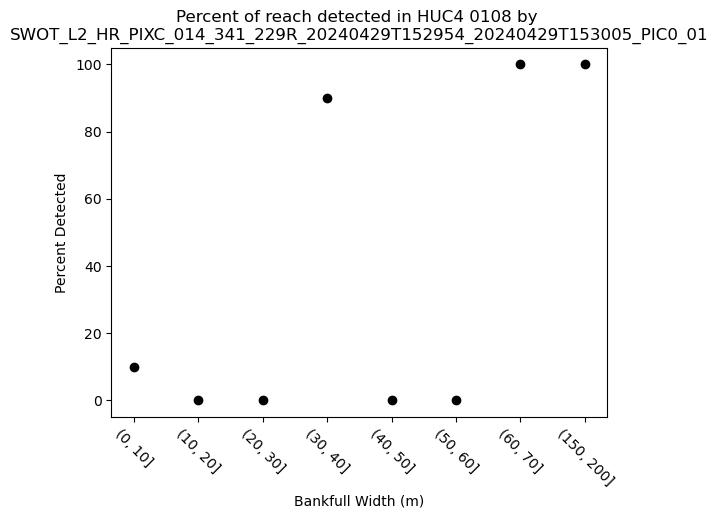

In [85]:
# plt.scatter(x=ordered, y=coverage, c='k')
plt.scatter(x=coverage.keys(), y=coverage.values(), c='k')
plt.title('Percent of reach detected in HUC4 0108 by \n'
          + tile_name)
plt.xticks(rotation=-45);
plt.xlabel('Bankfull Width (m)')
plt.ylabel('Percent Detected')
plt.savefig(fname='./figures_for_unit_test/one_tile_one_reach_per_bin.png', bbox_inches='tight')

#### TESTING

In [22]:
# Initialize lists
coverage = []
reach_bins = []

In [23]:
binn = bins[2]
binn

'(150, 200]'

In [24]:
reach = basin_crop.loc[basin_crop['Bin'] == binn].sample(n=1)

In [25]:
reach

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry
64496,"(150, 200]",Connecticut River,1.663,1.000090e+13,191.781368,"LINESTRING (-8083489.406 5213595.38, -8083505...."


<Axes: >

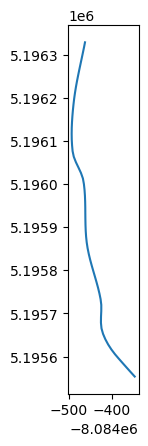

In [134]:
reach.plot()

In [135]:
reach_bins.append(reach.iloc[0,0])

In [136]:
reach_bins

['(150, 200]', '(150, 200]']

<Axes: >

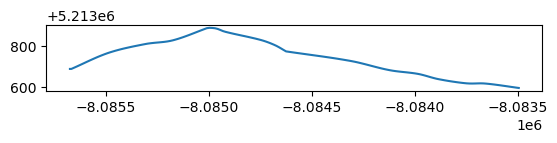

In [26]:
# Convert MultiLineString Z to LineString (returns GeoSeries)
gs = reach.geometry
gs.plot()

In [27]:
gs

64496    LINESTRING (-8083489.406 5213595.38, -8083505....
Name: geometry, dtype: geometry

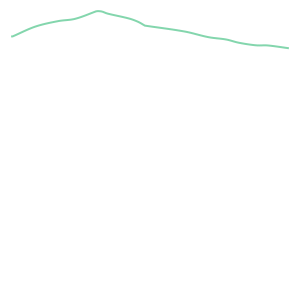

In [28]:
# Extract line segment from GeoSeries
line = gs[reach.index[0]]
line

In [139]:
print(line.length)

817.5229342573197


In [31]:
# Find length of segments
dist = line.length/10
print(dist)

225.97472903513147


In [32]:
# Make empty list for segments
segments = []

In [54]:
# Segment the reach
for i in range(9):
    # Chop the reach, store remainder
    new, line = cut(line=line, distance=dist)
    # Append new segment to GeoSeries of all segments
    segments.append(new)
# Append final segment of reach   
segments.append(line)

In [55]:
segments

[<LINESTRING (-8083489.406 5213595.38, -8083505.57 5213597.539, -8083518.951 ...>,
 <LINESTRING (-8083713.872 5213617.65, -8083720.506 5213617.522, -8083734.02 ...>,
 <LINESTRING (-8083936.494 5213652.436, -8083946.521 5213655.319, -8083959.59...>,
 <LINESTRING (-8084158.901 5213690.418, -8084159.542 5213690.566, -8084172.67...>,
 <LINESTRING (-8084379.499 5213738.698, -8084383.903 5213739.4, -8084397.261 ...>,
 <LINESTRING (-8084603.217 5213770.535, -8084611.388 5213771.725, -8084624.74...>,
 <LINESTRING (-8084814.588 5213845.193, -8084826.175 5213847.712, -8084839.41...>,
 <LINESTRING (-8085033.136 5213877.579, -8085034.966 5213876.895, -8085047.62...>,
 <LINESTRING (-8085249.538 5213816.665, -8085255.304 5213816.16, -8085268.826...>,
 <LINESTRING (-8085470.669 5213771.825, -8085480.058 5213768.922, -8085492.84...>]

In [57]:
# Make dict for constructing new GeoDataFrame
d = {}

In [58]:
for i in range(reach.shape[1]):
    d[reach.iloc[:,i].name] = reach.iloc[0,i]

In [59]:
d

{'Bin': '(150, 200]',
 'GNIS_Name': 'Connecticut River',
 'LengthKM': np.float64(1.663),
 'NHDPlusID': np.float64(10000900065602.0),
 'WidthM': np.float64(191.78136792049477),
 'geometry': <LINESTRING (-8083489.406 5213595.38, -8083505.57 5213597.539, -8083518.951 ...>}

In [ ]:
# Rename geometry for full reach
d['geometry_full'] = d['geometry']

In [ ]:
# Make GeoDataFrame with new reach segments
reach_cut = gpd.GeoDataFrame(data=d, index=range(len(segments)),
                             geometry=segments, crs=reach.crs)

In [145]:
reach_cut

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry,geometry_full
0,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084462.395 5196331.153, -8084464...",LINESTRING (-8084462.394799335 5196331.1526111...
1,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084478.966 5196251.099, -8084481...",LINESTRING (-8084462.394799335 5196331.1526111...
2,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084490.999 5196170.283, -8084492...",LINESTRING (-8084462.394799335 5196331.1526111...
3,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084492.726 5196088.648, -8084491...",LINESTRING (-8084462.394799335 5196331.1526111...
4,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084467.432 5196011.574, -8084465...",LINESTRING (-8084462.394799335 5196331.1526111...
5,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084462.072 5195930.128, -8084461...",LINESTRING (-8084462.394799335 5196331.1526111...
6,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084456.281 5195848.703, -8084454...",LINESTRING (-8084462.394799335 5196331.1526111...
7,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084435.355 5195769.707, -8084432...",LINESTRING (-8084462.394799335 5196331.1526111...
8,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084425.743 5195689.095, -8084425...",LINESTRING (-8084462.394799335 5196331.1526111...
9,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084399.485 5195613.583, -8084393...",LINESTRING (-8084462.394799335 5196331.1526111...


<Axes: >

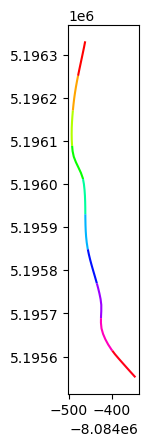

In [146]:
gpd.GeoSeries(segments).plot(cmap='hsv')

<Axes: >

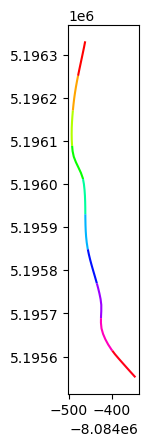

In [147]:
reach_cut.plot(cmap='hsv')

In [148]:
# Buffer the reach segments by 1/2 the calculated width
# CITE BEIGER
reach_cut['geometry'] = reach_cut.geometry.buffer(distance=(reach_cut.WidthM/2)[0], cap_style='flat')

<Axes: >

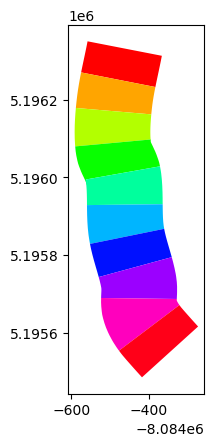

In [149]:
reach_cut.plot(cmap='hsv')

In [150]:
# Get pixels in reach
inside = gpd.sjoin(gdf_PIXC, reach_cut, how='inner', predicate='within').rename(columns={'index_right': 'segment'})

In [151]:
inside

,klass,geometry,segment,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry_full
551554,2.0,POINT (-8084426.802 5195500.297),9,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...
551557,5.0,POINT (-8084413.217 5195496.899),9,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...
552054,5.0,POINT (-8084440.054 5195533.887),9,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...
552055,5.0,POINT (-8084393.322 5195522.185),9,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...
552056,4.0,POINT (-8084406.989 5195525.61),9,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...
...,...,...,...,...,...,...,...,...,...
566534,4.0,POINT (-8084526.541 5196342.508),0,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...
566535,4.0,POINT (-8084486.889 5196332.579),0,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...
566536,4.0,POINT (-8084452.007 5196323.879),0,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...
566537,4.0,POINT (-8084414.85 5196314.574),0,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...


<Axes: >

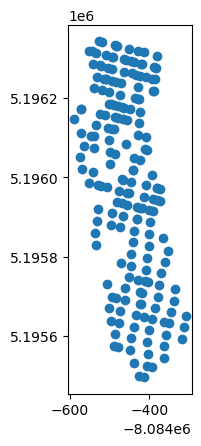

In [155]:
inside.plot()

In [156]:
if inside.empty:
    coverage = 0
else:    
    # Get number of pixels in each reach segment
    counts = pd.DataFrame(inside.segment.value_counts().reset_index().sort_index())
    print(counts)
    # Calculate coverage
    coverage = len(counts.loc[counts['count'] != 0])/len(counts.segment)

AttributeError: 'numpy.float64' object has no attribute 'DataFrame'